Using edge detector on deep layers of convolutional neural network.
Use the feature map resulting from deep convolutional neural network as images for edge detector and display the results.
(Note this code use Tensorflow implementation of VGG network by David Frossard, 2016.
 to use it you first need to download the pretrained model  weights from here: http://www.cs.toronto.edu/~frossard/post/vgg16/
And put them in the code folder.)

The  response of convolutional neural network in each layer is a matrix of size Dx*Dy*d were d  is the number of filters in this layer (can be considered as the layer depth). Dx and Dy are is the x,y dimension of the layer and is some fraction of the input image dimensions. By using the the response map of a given filter in in given layer (after RELU) as 2d  image of  dimension (Dx,Dy,1)  and applying  the sobel operator on this image,  it possible to get the gradient/edge map of this filter in this layer. Summing the absolute value of the sobel operator of all feature in an image give the Total gradient/edge map for this layer , which seem to be rather similar to gradient map of input  image.  

The code involve 3 steps:
1) Find  the feature  map of the of the image by applying the convolutional layers of the network.  The network used here is the VGG implementation for Tensorflow by David Frossard. The weight for this pre trained net should be download from here:http://www.cs.toronto.edu/~frossard/post/vgg16/ and put in code directory.

2) Use the sobel operator to to get  gradient map for each filter in a given convolutional  layer.

3) Take the average of response map of all filters in a given layer to get the total edge map of this layer.

4) Resize the edge map to feet the original image size.



Part 1: Firstbuild the convolutional part of vgg network using code from  Davi Frossard, 2016
Network weight should be predownload from http://www.cs.toronto.edu/~frossard/post/vgg16/  

In [1]:
########################################################################################
# Davi Frossard, 2016                                                                  #
# VGG16 implementation in TensorFlow                                                   #
# Details:                                                                             #
# http://www.cs.toronto.edu/~frossard/post/vgg16/                                      #
#                                                                                      #
# Model from https://gist.github.com/ksimonyan/211839e770f7b538e2d8#file-readme-md     #
# Weights from Caffe converted using https://github.com/ethereon/caffe-tensorflow      #
########################################################################################

import tensorflow as tf
import numpy as np
from scipy.misc import imread, imresize
from imagenet_classes import class_names

###############################CLASS###########################################################
class vgg16:
    def __init__(self, imgs, weights=None, sess=None):#Intitiate network graph and load weight
        self.imgs = imgs
        self.convlayers() #build convolutional layers of vgg network
        
        if weights is not None and sess is not None:
            self.load_weights(weights, sess) #Load network weight


    def convlayers(self):#build convolutional layers of vgg network
        self.parameters = []

        # zero-mean input
        with tf.name_scope('preprocess') as scope:
            mean = tf.constant([123.68, 116.779, 103.939], dtype=tf.float32, shape=[1, 1, 1, 3], name='img_mean')
            images = self.imgs-mean

        # conv1_1
        with tf.name_scope('conv1_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 3, 64], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv1_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv1_2
        with tf.name_scope('conv1_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 64], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv1_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv1_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool1
        self.pool1 = tf.nn.max_pool(self.conv1_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool1')

        # conv2_1
        with tf.name_scope('conv2_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 64, 128], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv2_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv2_2
        with tf.name_scope('conv2_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 128], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv2_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv2_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool2
        self.pool2 = tf.nn.max_pool(self.conv2_2,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool2')

        # conv3_1
        with tf.name_scope('conv3_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 128, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv3_2
        with tf.name_scope('conv3_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv3_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv3_3
        with tf.name_scope('conv3_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv3_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool3
        self.pool3 = tf.nn.max_pool(self.conv3_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool3')

        # conv4_1
        with tf.name_scope('conv4_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 256, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool3, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv4_2
        with tf.name_scope('conv4_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv4_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv4_3
        with tf.name_scope('conv4_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv4_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool4
        self.pool4 = tf.nn.max_pool(self.conv4_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool4')

        # conv5_1
        with tf.name_scope('conv5_1') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.pool4, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_1 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv5_2
        with tf.name_scope('conv5_2') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv5_1, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_2 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # conv5_3
        with tf.name_scope('conv5_3') as scope:
            kernel = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.conv5_2, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_3 = tf.nn.relu(out, name=scope)
            self.parameters += [kernel, biases]

        # pool5
        self.pool5 = tf.nn.max_pool(self.conv5_3,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME',
                               name='pool4')


    def load_weights(self, weight_file, sess):#Load network weight
        weights = np.load(weight_file)
        keys = sorted(weights.keys())
        for i, k in enumerate(keys):
            if (i<len(self.parameters)):
                  print(i, k, np.shape(weights[k]),len(self.parameters));
                  sess.run(self.parameters[i].assign(weights[k]))

/home/chucha/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


ModuleNotFoundError: No module named 'imagenet_classes'

Load image and intitiate the neural network

In [2]:
sess = tf.Session()
img1 = imread('000081.png', mode='RGB')#Load image

Sy,Sx,dpt=img1.shape#Get image shape 
imgs = tf.placeholder(tf.float32, [None, Sy, Sx, 3])
vgg = vgg16(imgs, 'vgg16_weights.npz', sess)# Initiate neural network

0 conv1_1_W (3, 3, 3, 64) 26
1 conv1_1_b (64,) 26
2 conv1_2_W (3, 3, 64, 64) 26
3 conv1_2_b (64,) 26
4 conv2_1_W (3, 3, 64, 128) 26
5 conv2_1_b (128,) 26
6 conv2_2_W (3, 3, 128, 128) 26
7 conv2_2_b (128,) 26
8 conv3_1_W (3, 3, 128, 256) 26
9 conv3_1_b (256,) 26
10 conv3_2_W (3, 3, 256, 256) 26
11 conv3_2_b (256,) 26
12 conv3_3_W (3, 3, 256, 256) 26
13 conv3_3_b (256,) 26
14 conv4_1_W (3, 3, 256, 512) 26
15 conv4_1_b (512,) 26
16 conv4_2_W (3, 3, 512, 512) 26
17 conv4_2_b (512,) 26
18 conv4_3_W (3, 3, 512, 512) 26
19 conv4_3_b (512,) 26
20 conv5_1_W (3, 3, 512, 512) 26
21 conv5_1_b (512,) 26
22 conv5_2_W (3, 3, 512, 512) 26
23 conv5_2_b (512,) 26
24 conv5_3_W (3, 3, 512, 512) 26
25 conv5_3_b (512,) 26


Run the convolutional network on image and get the response of all convolutiona layers 

In [3]:
conv1_1, conv1_2, conv2_1, conv2_2, conv3_1,conv3_2,conv3_3, conv4_1, conv4_2, conv4_3,conv5_1, conv5_2, conv5_3=sess.run([vgg.conv1_1, vgg.conv1_2, vgg.conv2_1, vgg.conv2_2, vgg.conv3_1,vgg.conv3_2,vgg.conv3_3, vgg.conv4_1, vgg.conv4_2, vgg.conv4_3,vgg.conv5_1, vgg.conv5_2, vgg.conv5_3], feed_dict={vgg.imgs: [img1]})

In [4]:
#Get response of pooling layers (not used)
#p1, p2, p3,p4,p5=sess.run([vgg.pool1, vgg.pool2, vgg.pool3, vgg.pool4, vgg.pool5], feed_dict={vgg.imgs: [img1]})

Apply sobel oprator of response map of specific layer in the net to get its total gradient/edge map of this layer 

In [37]:
from scipy import signal
from scipy import misc
for i in range(1,2):
    path_major='Data/'+str(i)
    for j in range(1,2):
        im=array(Image.open(path_major+"/7.jpg"))
        imf=array(Image.open(path_major+"/7.jpg"))
for ii in range(1,2): 
    im=im.squeeze()#Remove acces dimension
    im=np.swapaxes(im,0,2)#Swap axes to feet thos of standart image (x,y,d)
    im=np.swapaxes(im,1,2)
    Gx=[[1,2,1], [0 , 0 ,0],[-1,-2,-1]]#Build sobel x,y gradient filters
    Gy=np.swapaxes(Gx,0,1)#Build sobel x,y gradient filters
    ndim=im[:,1,1].shape[0]# Get the depth (number of filter of the layer)
    print(ndim)
    TotGrad=np.zeros(im[1,:,:].shape) #The averge gradient map of the image to be filled later
    im1=np.zeros(imf.shape)
    for ii in range(ndim):# Go over all dimensions (filters) 
       print(ii);
       gradx = signal.convolve2d(im[ii,:,:],Gx,  boundary='symm',mode='same');#Get x sobel response of ii layer
       grady = signal.convolve2d(im[ii,:,:],Gy,  boundary='symm',mode='same');#Get y sobel response of ii layer
       grad=np.sqrt(np.power(gradx,2)+np.power(grady,2));#Get total sobel response of ii layer
       im1[:,:,ii]=imf[:,:,ii]
       TotGrad+=grad#Add add to the layer average gradient/edge map 
    TotGrad/=ndim#Get layer sobel gradient map
    print(im1.shape)
    scipy.misc.imsave('res/1.jpg', grady)
    scipy.misc.imsave('res/1f.jpg', imf)
    scipy.misc.imsave('res/11.jpg', im1)

    

3
0
1
2
(240, 320, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [33]:
from keras.layers import Input, Dense , merge
from keras.layers.core import Reshape
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv2D,MaxPooling2D,UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adadelta, RMSprop
import os
import os.path
import numpy as np
import numpy 
from PIL import Image
from numpy import * 
# SKLEARN
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import scipy.misc
import math

Same as deep sobel only resize output to a given size

In [6]:
def SSobel(im,sp):
    TotGrad=DeepSobel(im)
    NewGrad=misc.imresize(TotGrad, sp,  interp='bicubic')# (‘nearest’,‘bilinear’ , ‘bicubic’ or ‘cubic’)
    print("New Size",NewGrad.shape)
    return NewGrad

Display edge/gradient map for the responses all convolutional layers in the images

Display edge/gradient map for the responses all convolutional layers in the images
Input image


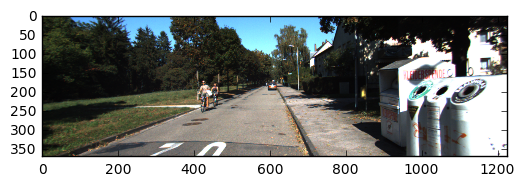

Layer Name: conv1_1
In original size


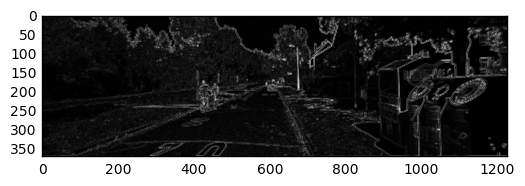

In image size
New Size (370, 1226)


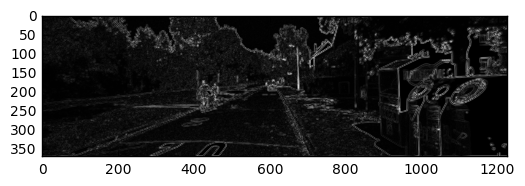

Layer Name: conv1_2
In original size


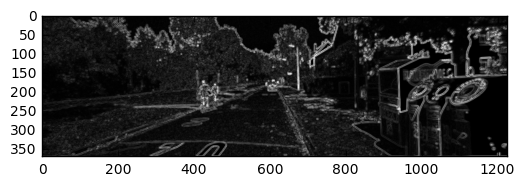

In image size
New Size (370, 1226)


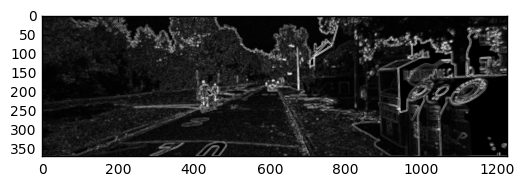

Layer Name: conv2_1
In original size


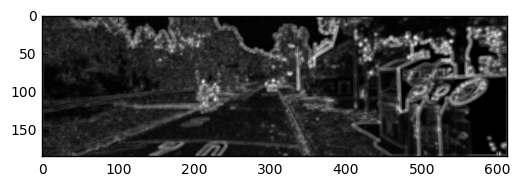

In image size
New Size (370, 1226)


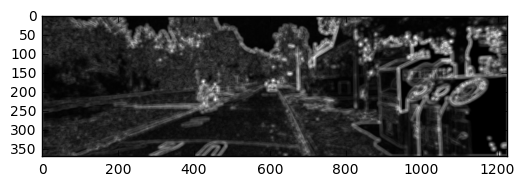

Layer Name: conv2_2
In original size


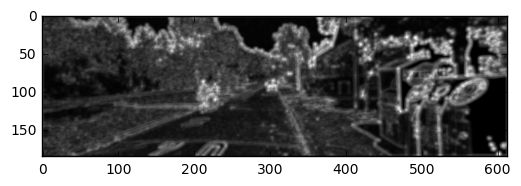

In image size
New Size (370, 1226)


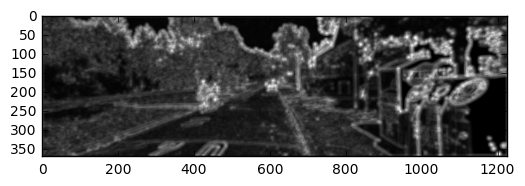

Layer Name: conv3_1
In original size


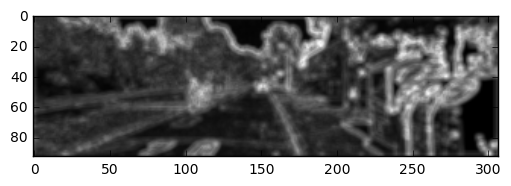

In image size
New Size (370, 1226)


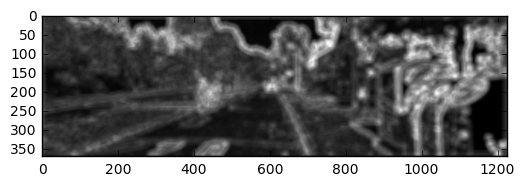

Layer Name: conv3_2
In original size


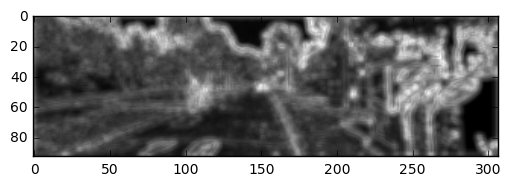

In image size
New Size (370, 1226)


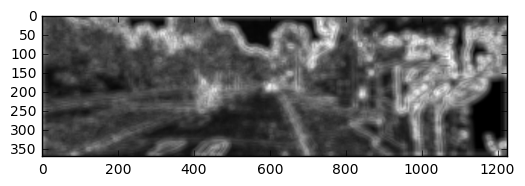

Layer Name: conv3_3
In original size


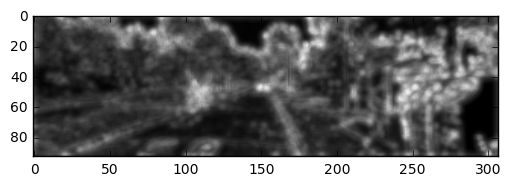

In image size
New Size (370, 1226)


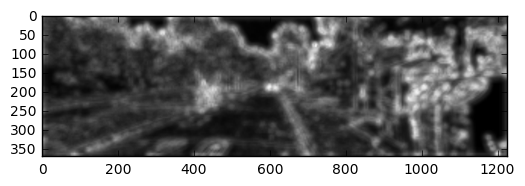

Layer Name: conv4_1
In original size


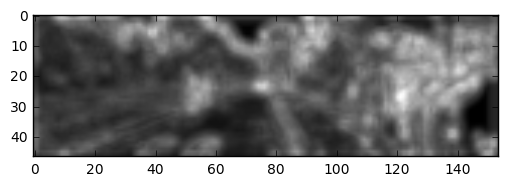

In image size
New Size (370, 1226)


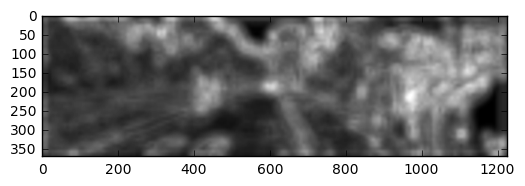

Layer Name: conv4_2
In original size


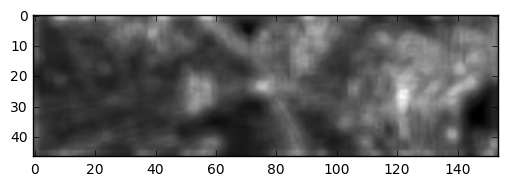

In image size
New Size (370, 1226)


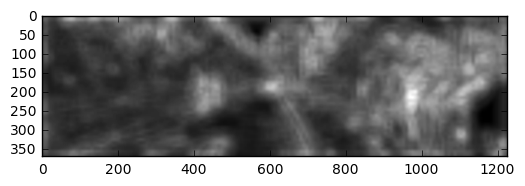

Layer Name: conv4_3
In original size


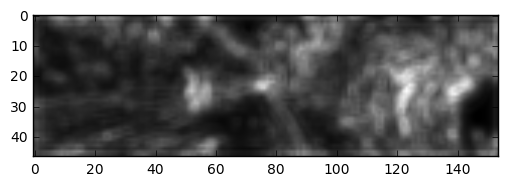

In image size
New Size (370, 1226)


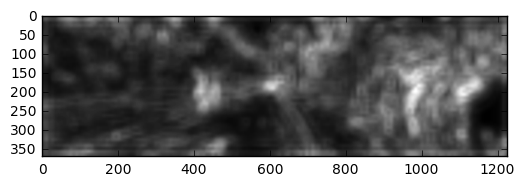

Layer Name: conv5_1
In original size


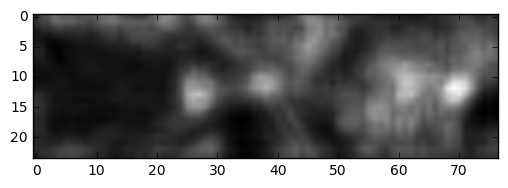

In image size
New Size (370, 1226)


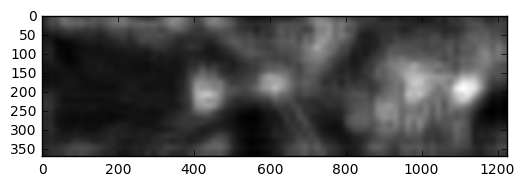

Layer Name: conv5_2
In original size


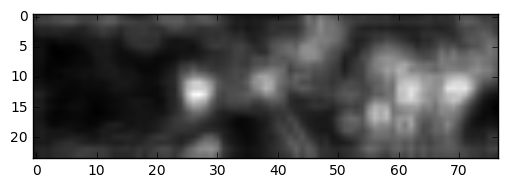

In image size
New Size (370, 1226)


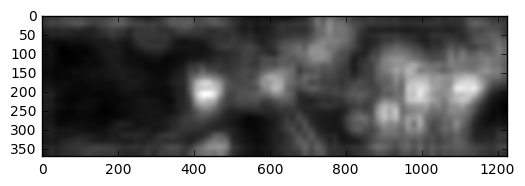

Layer Name: conv5_3
In original size


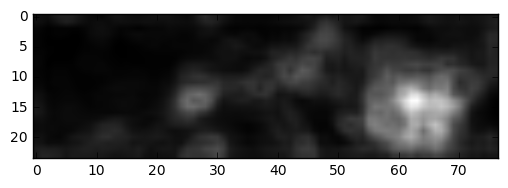

In image size
New Size (370, 1226)


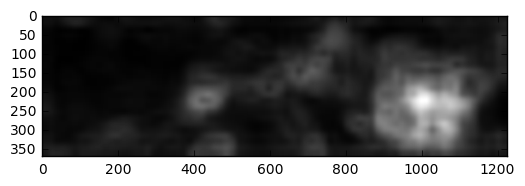

In [7]:
import matplotlib.pyplot as plt
print('Display edge/gradient map for the responses all convolutional layers in the images')
#................Original image........................................................
print('Input image')
plt.imshow(img1)
plt.gray()
plt.show()
#....................11................................................................
print('Layer Name: conv1_1')
print('In original size')
plt.imshow(DeepSobel(conv1_1))
plt.gray()
plt.show()

print('In image size')
plt.imshow(SSobel(conv1_1,img1[:,:,1].shape))
plt.gray()
plt.show()
#...................12...............................................................
print('Layer Name: conv1_2')
print('In original size')
plt.imshow(DeepSobel(conv1_2))
plt.gray()
plt.show()

print('In image size')
plt.imshow(SSobel(conv1_2,img1[:,:,1].shape))
plt.gray()
plt.show()
#...................21...............................................................
print('Layer Name: conv2_1')
print('In original size')
plt.imshow(DeepSobel(conv2_1))
plt.gray()
plt.show()

print('In image size')
plt.imshow(SSobel(conv2_1,img1[:,:,1].shape))
plt.gray()
plt.show()
#..................22................................................................
print('Layer Name: conv2_2')
print('In original size')
plt.imshow(DeepSobel(conv2_2))
plt.gray()
plt.show()

print('In image size')
plt.imshow(SSobel(conv2_2,img1[:,:,1].shape))
plt.gray()
plt.show()
#..................31................................................................
print('Layer Name: conv3_1')
print('In original size')
plt.imshow(DeepSobel(conv3_1))
plt.gray()
plt.show()

print('In image size')
plt.imshow(SSobel(conv3_1,img1[:,:,1].shape))
plt.gray()
plt.show()
#..................32................................................................
print('Layer Name: conv3_2')
print('In original size')
plt.imshow(DeepSobel(conv3_2))
plt.gray()
plt.show()

print('In image size')
plt.imshow(SSobel(conv3_2,img1[:,:,1].shape))
plt.gray()
plt.show()
#.....................33.............................................................
print('Layer Name: conv3_3')
print('In original size')
plt.imshow(DeepSobel(conv3_3))
plt.gray()
plt.show()

print('In image size')
plt.imshow(SSobel(conv3_3,img1[:,:,1].shape))
plt.gray()
plt.show()
#..................41................................................................
print('Layer Name: conv4_1')
print('In original size')
plt.imshow(DeepSobel(conv4_1))
plt.gray()
plt.show()

print('In image size')
plt.imshow(SSobel(conv4_1,img1[:,:,1].shape))
plt.gray()
plt.show()
#..................42................................................................
print('Layer Name: conv4_2')
print('In original size')
plt.imshow(DeepSobel(conv4_2))
plt.gray()
plt.show()

print('In image size')
plt.imshow(SSobel(conv4_2,img1[:,:,1].shape))
plt.gray()
plt.show()
#.....................43.............................................................
print('Layer Name: conv4_3')
print('In original size')
plt.imshow(DeepSobel(conv4_3))
plt.gray()
plt.show()

print('In image size')
plt.imshow(SSobel(conv4_3,img1[:,:,1].shape))
plt.gray()
plt.show()
#..................51................................................................
print('Layer Name: conv5_1')
print('In original size')
plt.imshow(DeepSobel(conv5_1))
plt.gray()
plt.show()

print('In image size')
plt.imshow(SSobel(conv5_1,img1[:,:,1].shape))
plt.gray()
plt.show()
#..................52................................................................
print('Layer Name: conv5_2')
print('In original size')
plt.imshow(DeepSobel(conv5_2))
plt.gray()
plt.show()

print('In image size')
plt.imshow(SSobel(conv5_2,img1[:,:,1].shape))
plt.gray()
plt.show()
#.....................53.............................................................
print('Layer Name: conv5_3')
print('In original size')
plt.imshow(DeepSobel(conv5_3))
plt.gray()
plt.show()

print('In image size')
plt.imshow(SSobel(conv5_3,img1[:,:,1].shape))
plt.gray()
plt.show()



Next examine the sobel edge map of independent filters in each layer

In [31]:
from scipy import signal
from scipy import misc

def DisplaySobelResultsforAllFilters(im,LayerName): #Apply sobel oprator of response map to all filters respones map in given layer and display the results 
    im=im.squeeze()#Remove acces dimension
    im=np.swapaxes(im,0,2)#Swap axes to feet thos of standart image (x,y,d)
    im=np.swapaxes(im,1,2)
    Gx=[[1,2,1], [0 , 0 ,0],[-1,-2,-1]]#Build sobel x,y gradient filters
    Gy=np.swapaxes(Gx,0,1)#Build sobel x,y gradient filters
    ndim=im[:,1,1].shape[0]# Get the depth (number of filter of the layer)
    TotGrad=np.zeros(im[1,:,:].shape) #The averge gradient map of the image to be filled later

    for ii in range(ndim):# Go over all dimensions (filters) 
       print(LayerName,'    Filter: ',ii+1);
       gradx = signal.convolve2d(im[ii,:,:],Gx,  boundary='symm',mode='same');#Get x sobel response of ii layer
       grady = signal.convolve2d(im[ii,:,:],Gy,  boundary='symm',mode='same');#Get y sobel response of ii layer
       grad=np.sqrt(np.power(gradx,2)+np.power(grady,2));#Get total sobel response of ii layer 
       plt.imshow(grad)#Display results for filter
       plt.gray()
       plt.show()


Display sobel gradient map for all filters in all layers 

Display sobel gradient map for all filters in all layers
Input image


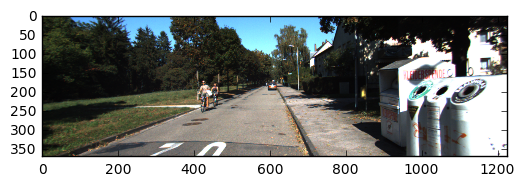

Layer Name: conv1_1
conv1_1     Filter:  0


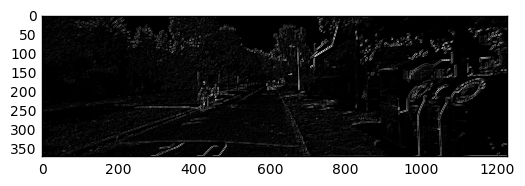

conv1_1     Filter:  1


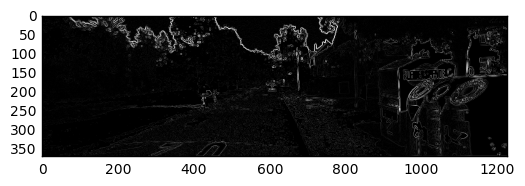

conv1_1     Filter:  2


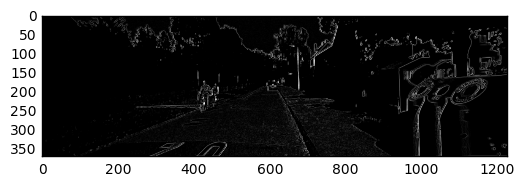

conv1_1     Filter:  3


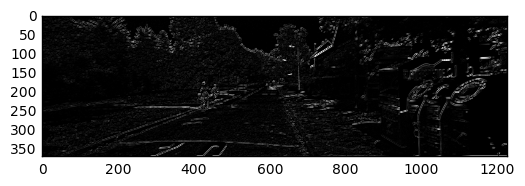

conv1_1     Filter:  4


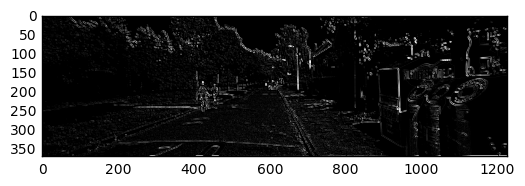

conv1_1     Filter:  5


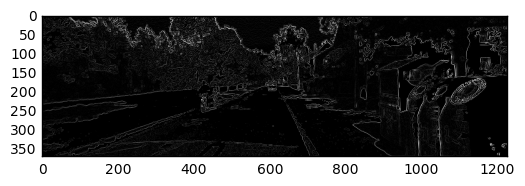

conv1_1     Filter:  6


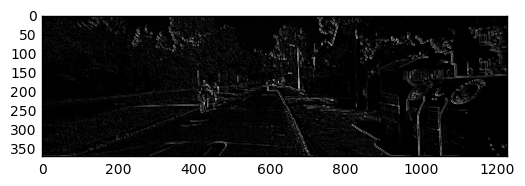

conv1_1     Filter:  7


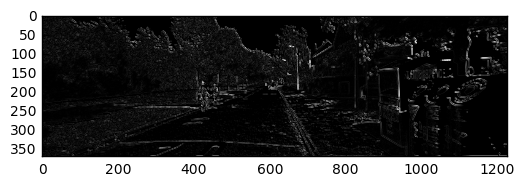

conv1_1     Filter:  8


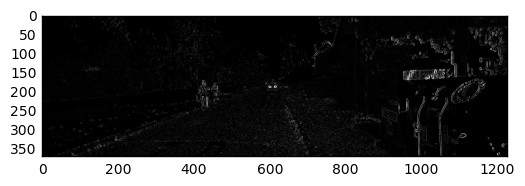

conv1_1     Filter:  9


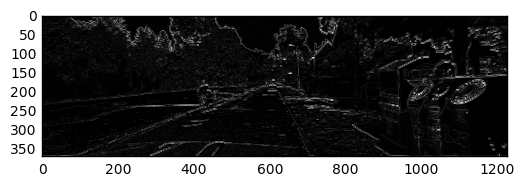

conv1_1     Filter:  10


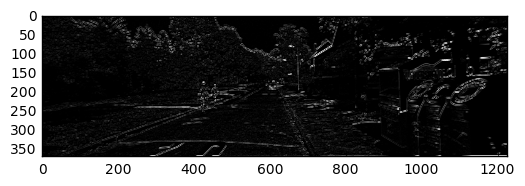

conv1_1     Filter:  11


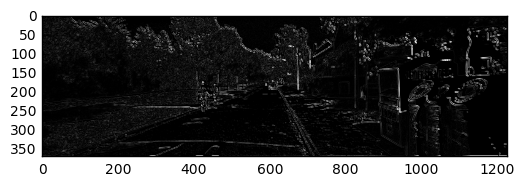

conv1_1     Filter:  12


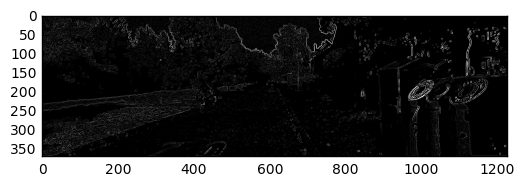

conv1_1     Filter:  13


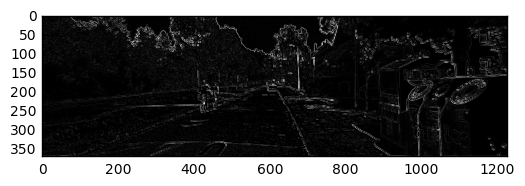

conv1_1     Filter:  14


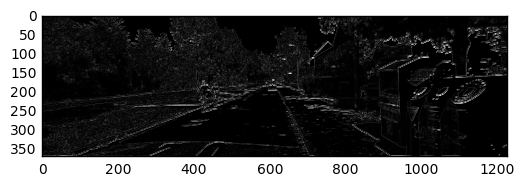

conv1_1     Filter:  15


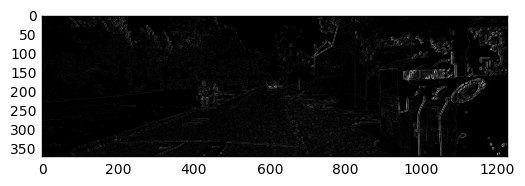

conv1_1     Filter:  16


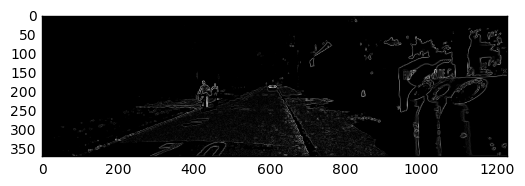

conv1_1     Filter:  17


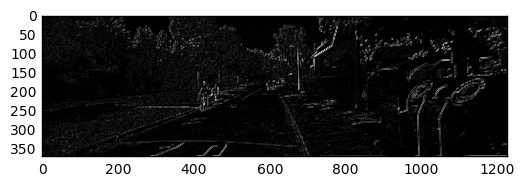

conv1_1     Filter:  18


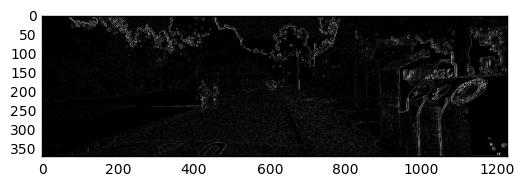

conv1_1     Filter:  19


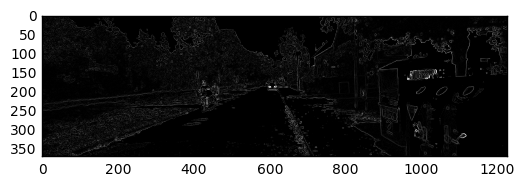

conv1_1     Filter:  20


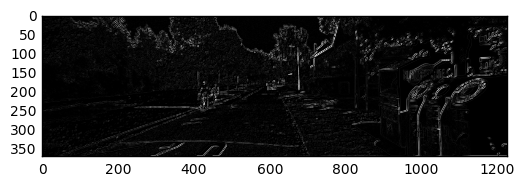

conv1_1     Filter:  21


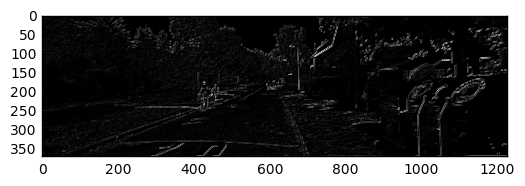

conv1_1     Filter:  22


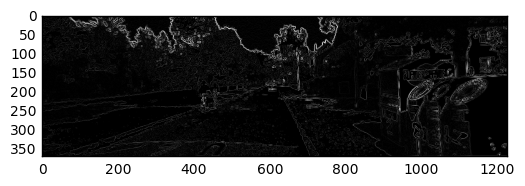

conv1_1     Filter:  23


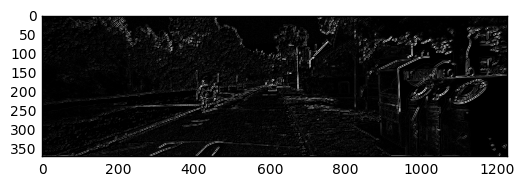

conv1_1     Filter:  24


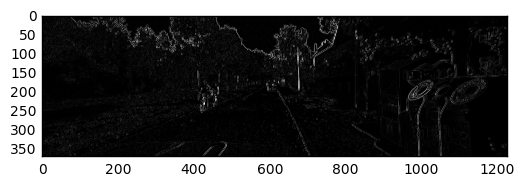

conv1_1     Filter:  25


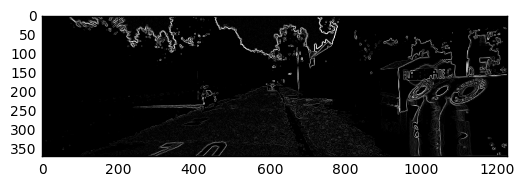

conv1_1     Filter:  26


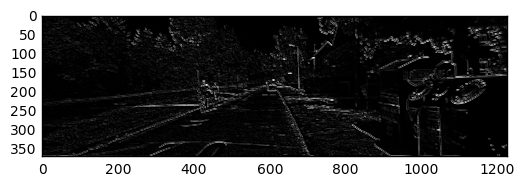

conv1_1     Filter:  27


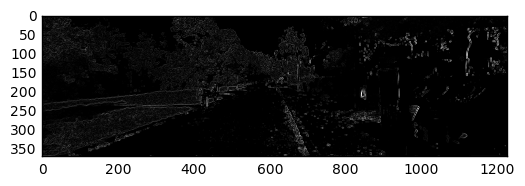

conv1_1     Filter:  28


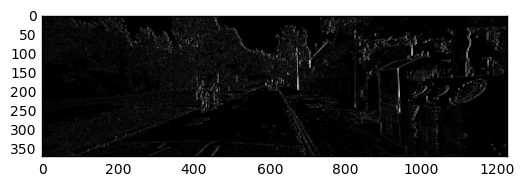

conv1_1     Filter:  29


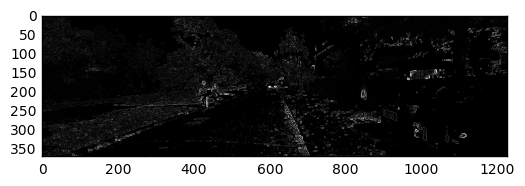

conv1_1     Filter:  30


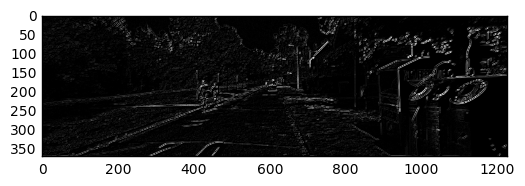

conv1_1     Filter:  31


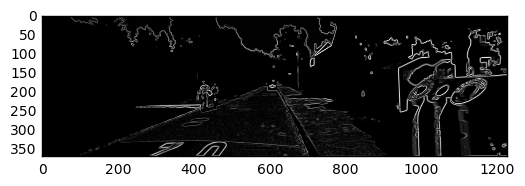

conv1_1     Filter:  32


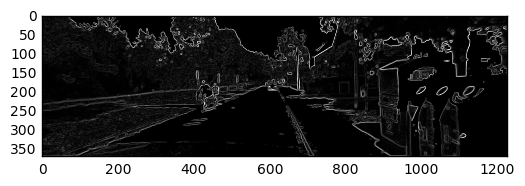

conv1_1     Filter:  33


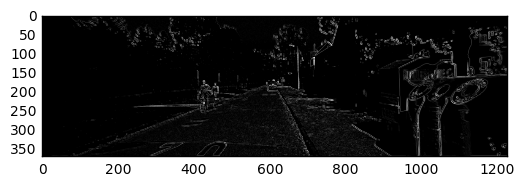

conv1_1     Filter:  34


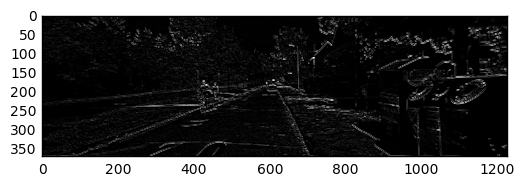

conv1_1     Filter:  35


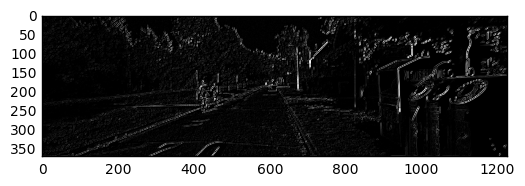

conv1_1     Filter:  36


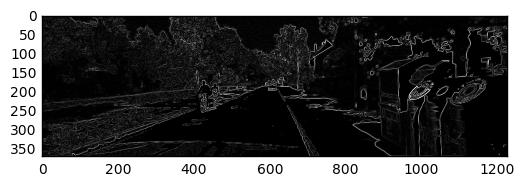

conv1_1     Filter:  37


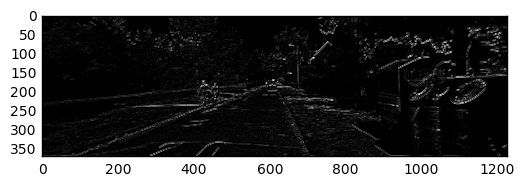

conv1_1     Filter:  38


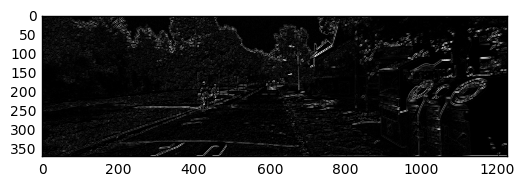

conv1_1     Filter:  39


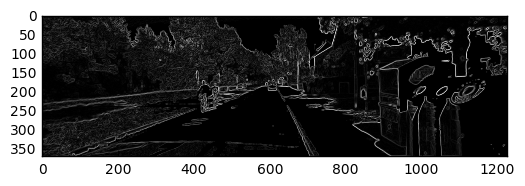

conv1_1     Filter:  40


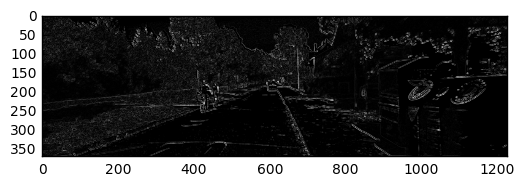

conv1_1     Filter:  41


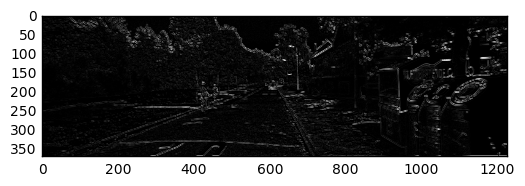

conv1_1     Filter:  42


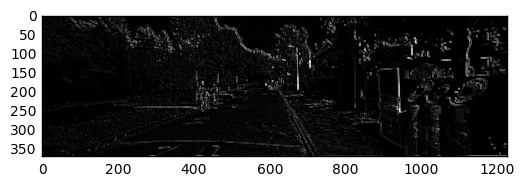

conv1_1     Filter:  43


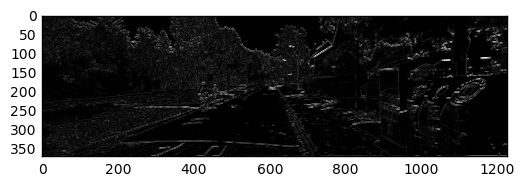

conv1_1     Filter:  44


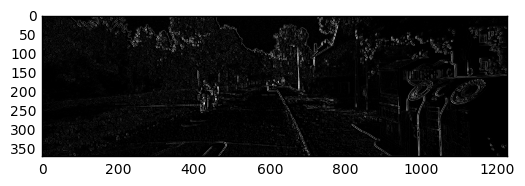

conv1_1     Filter:  45


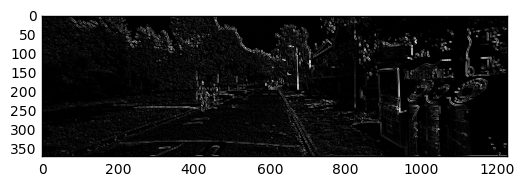

conv1_1     Filter:  46


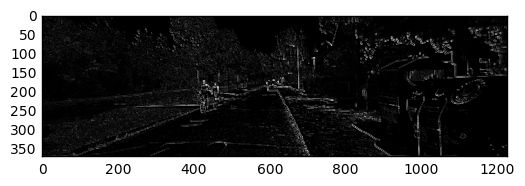

conv1_1     Filter:  47


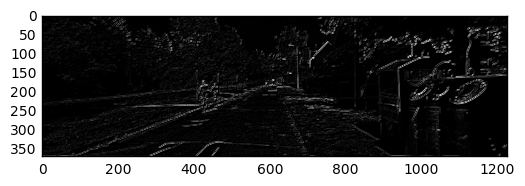

conv1_1     Filter:  48


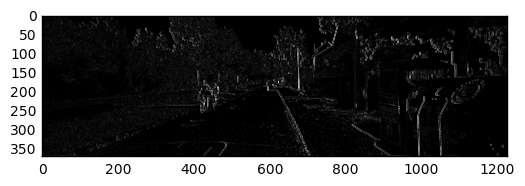

conv1_1     Filter:  49


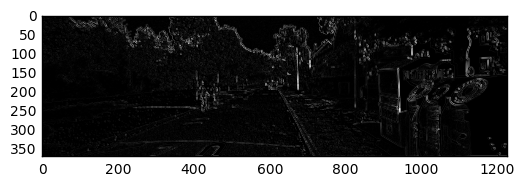

conv1_1     Filter:  50


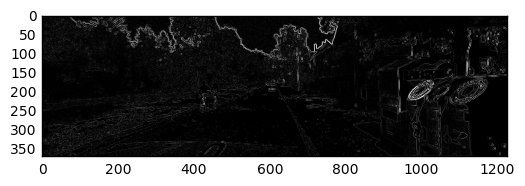

conv1_1     Filter:  51


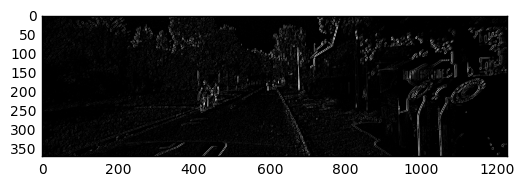

conv1_1     Filter:  52


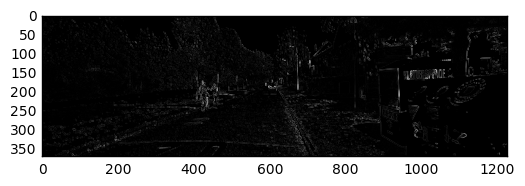

conv1_1     Filter:  53


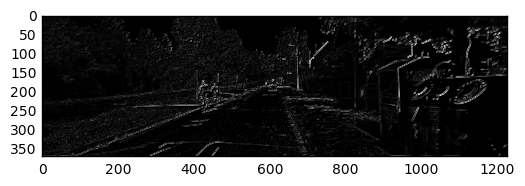

conv1_1     Filter:  54


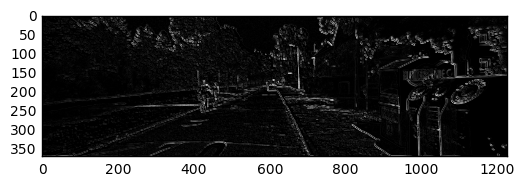

conv1_1     Filter:  55


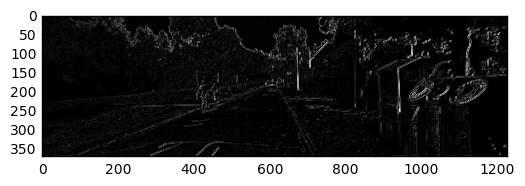

In [ ]:
print('Display sobel gradient map for all filters in all layers')
#................Original image........................................................
print('Input image')
plt.imshow(img1)
plt.gray()
plt.show()
#....................11................................................................
print('Layer Name: conv1_1')
DisplaySobelResultsforAllFilters(conv1_1,'conv1_1')
#....................12................................................................
print('Layer Name: conv1_2')
DisplaySobelResultsforAllFilters(conv1_2,'conv1_2')
#....................21................................................................
print('Layer Name: conv2_1')
DisplaySobelResultsforAllFilters(conv2_1,'conv2_1')
#....................22................................................................
print('Layer Name: conv2_2')
DisplaySobelResultsforAllFilters(conv2_2,'conv2_2')
#....................32................................................................
print('Layer Name: conv3_2')
DisplaySobelResultsforAllFilters(conv3_2,'conv3_2')
#....................33................................................................
print('Layer Name: conv3_3')
DisplaySobelResultsforAllFilters(conv3_3,'conv3_3')
#....................41................................................................
print('Layer Name: conv4_1')
DisplaySobelResultsforAllFilters(conv4_1,'conv4_1')
#....................42................................................................
print('Layer Name: conv4_2')
DisplaySobelResultsforAllFilters(conv4_2,'conv4_2')
#....................43................................................................
print('Layer Name: conv4_3')
DisplaySobelResultsforAllFilters(conv4_3,'conv4_3')

#....................51................................................................
print('Layer Name: conv5_1')
DisplaySobelResultsforAllFilters(conv5_1,'conv5_1')
#....................52................................................................
print('Layer Name: conv5_2')
DisplaySobelResultsforAllFilters(conv5_2,'conv5_2')
#....................53................................................................
print('Layer Name: conv5_3')
DisplaySobelResultsforAllFilters(conv5_3,'conv5_3')

